In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Union, Optional

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

import torch
from torch import nn, Tensor
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC

from aim import Run
from tqdm.auto import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [2]:
train_data, test_data = pd.read_csv('./data/loan_train.csv'), pd.read_csv('./data/loan_test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52780 entries, 0 to 52779
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          52780 non-null  int64  
 1   person_age                  52780 non-null  int64  
 2   person_income               52780 non-null  int64  
 3   person_home_ownership       52780 non-null  object 
 4   person_emp_length           52780 non-null  float64
 5   loan_intent                 52780 non-null  object 
 6   loan_grade                  52780 non-null  object 
 7   loan_amnt                   52780 non-null  int64  
 8   loan_int_rate               52780 non-null  float64
 9   loan_percent_income         52780 non-null  float64
 10  cb_person_default_on_file   52780 non-null  object 
 11  cb_person_cred_hist_length  52780 non-null  int64  
 12  loan_status                 52780 non-null  int64  
dtypes: float64(3), int64(6), object

In [4]:
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52780.000000,52780.000000,5.278000e+04,52780.000000,52780.000000,52780.000000,52780.000000,52780.000000,52780.000000
mean,29323.588291,27.554926,6.396906e+04,4.696192,9210.809530,10.678262,0.159226,5.815517,0.142383
std,16936.066613,6.046298,3.611165e+04,3.966526,5560.086455,3.038162,0.091758,4.037774,0.349446
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14669.750000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,44002.250000,30.000000,7.540000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.200000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [5]:
display(train_data.head())
display(test_data.head())

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,42788,21,102000,MORTGAGE,5.0,EDUCATION,A,10000,7.51,0.10,N,4,0
1,11553,23,49000,RENT,1.0,HOMEIMPROVEMENT,D,5000,13.17,0.10,Y,4,1
2,27481,23,30000,RENT,1.0,MEDICAL,B,10000,11.99,0.33,N,4,1
3,39841,32,95000,MORTGAGE,9.0,HOMEIMPROVEMENT,C,15000,12.84,0.16,Y,5,0
4,55662,31,32000,MORTGAGE,3.0,HOMEIMPROVEMENT,A,1200,7.68,0.04,N,10,0


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,35352,39,60000,MORTGAGE,5.0,EDUCATION,A,12000,7.88,0.20,N,12,0
1,5114,25,65000,MORTGAGE,9.0,EDUCATION,B,7000,12.42,0.11,N,4,0
2,33050,22,72000,MORTGAGE,6.0,PERSONAL,D,2000,14.84,0.03,N,2,0
3,14668,23,24000,RENT,3.0,DEBTCONSOLIDATION,B,8000,10.99,0.33,N,2,1
4,298,31,56000,RENT,1.0,MEDICAL,B,2500,11.49,0.04,N,9,0


In [6]:
categorical_features = train_data.select_dtypes('object')

for feature in categorical_features:
    print(feature)
    print(sorted(train_data[feature].unique()))
    print(sorted(test_data[feature].unique()), end='\n\n')

person_home_ownership
['MORTGAGE', 'OTHER', 'OWN', 'RENT']
['MORTGAGE', 'OTHER', 'OWN', 'RENT']

loan_intent
['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']
['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']

loan_grade
['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A', 'B', 'C', 'D', 'E', 'F', 'G']

cb_person_default_on_file
['N', 'Y']
['N', 'Y']



In [7]:
categories = {
    'person_home_ownership' : {
        'MORTGAGE' : 0,
        'RENT'     : 1,
        'OWN'      : 2,
        'OTHER'    : 3
    },
    'loan_intent' : {
        'EDUCATION'         : 0,
        'HOMEIMPROVEMENT'   : 1,
        'MEDICAL'           : 2,
        'DEBTCONSOLIDATION' : 3,
        'VENTURE'           : 4,
        'PERSONAL'          : 5
    },
    'loan_grade' : {
        'A' : 0,
        'B' : 1,
        'C' : 2,
        'D' : 3,
        'E' : 4,
        'F' : 5,
        'G' : 6
    },
    'cb_person_default_on_file' : {
        'N' : 0,
        'Y' : 1
    }
}

In [8]:
print(train_data.isna().sum(), test_data.isna().sum(), sep='\n\n')

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [9]:
for col in train_data.select_dtypes('number'):
    print(f'{col}: max - {max(train_data[col].max(), test_data[col].max())}, min - {min(train_data[col].min(), test_data[col].min())}')

id: max - 58644, min - 0
person_age: max - 123, min - 20
person_income: max - 1900000, min - 4200
person_emp_length: max - 123.0, min - 0.0
loan_amnt: max - 35000, min - 500
loan_int_rate: max - 23.22, min - 5.42
loan_percent_income: max - 0.83, min - 0.0
cb_person_cred_hist_length: max - 30, min - 2
loan_status: max - 1, min - 0


In [10]:
class LoanDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item: int) -> dict[str, dict[str | Tensor] | Tensor]:
        item = self._data.iloc[item]
        return {
            'target': torch.scalar_tensor(item['loan_status'], dtype=torch.float32),
            'cat_features': {
                'home'   : torch.scalar_tensor(categories['person_home_ownership'][item['person_home_ownership']], dtype=torch.long),
                'intent': torch.scalar_tensor(categories['loan_intent'][item['loan_intent']], dtype=torch.long),
                'grade' : torch.scalar_tensor(categories['loan_grade'][item['loan_grade']], dtype=torch.long),
                'cpdof' : torch.scalar_tensor(categories['cb_person_default_on_file'][item['cb_person_default_on_file']], dtype=torch.long)
            },
            'numeric_features': {
                'age': torch.scalar_tensor(item['person_age'] / 123, dtype=torch.float32),
                'income': torch.scalar_tensor(item['person_income'] / 1900000, dtype=torch.float32),
                'emp': torch.scalar_tensor(item['person_emp_length'] / 123, dtype=torch.float32),
                'amnt': torch.scalar_tensor(item['loan_amnt'] / 35000, dtype=torch.float32),
                'rate': torch.scalar_tensor(item['loan_int_rate'] / 24, dtype=torch.float32),
                'p_income': torch.scalar_tensor(item['loan_percent_income'], dtype=torch.float32),  # Changed to match collator
                'cred_hist': torch.scalar_tensor(item['cb_person_cred_hist_length'] / 30, dtype=torch.float32),
            }
        }


In [11]:
class LoanCollator:
    def __call__(self, items: list[dict[str, dict[str | Tensor] | Tensor]]) -> dict[str, dict[str | Tensor] | Tensor]:
        return {
            'target': torch.stack([x['target'] for x in items]),
            'cat_features': {
                'home'   : torch.stack([x['cat_features']['home'] for x in items]),
                'intent': torch.stack([x['cat_features']['intent'] for x in items]),
                'grade' : torch.stack([x['cat_features']['grade'] for x in items]),
                'cpdof' : torch.stack([x['cat_features']['cpdof'] for x in items])
            },
            'numeric_features': {
                'age'    : torch.stack([x['numeric_features']['age'] for x in items]),
                'income' : torch.stack([x['numeric_features']['income'] for x in items]),
                'emp'    : torch.stack([x['numeric_features']['emp'] for x in items]),
                'amnt'   : torch.stack([x['numeric_features']['amnt'] for x in items]),
                'rate'   : torch.stack([x['numeric_features']['rate'] for x in items]),
                'p_income': torch.stack([x['numeric_features']['p_income'] for x in items]),
                'cred_hist'  : torch.stack([x['numeric_features']['cred_hist'] for x in items])
            }
        }
        

In [12]:
train_dataset, test_dataset = LoanDataset(train_data), LoanDataset(test_data)

In [13]:
def map_to_device(batch: dict, dev: torch.device) -> dict:
    batch['target'] = batch['target'].to(dev)

    for (name, feature) in batch['cat_features'].items():
        batch['cat_features'][name] = feature.to(dev)

    for (name, feature) in batch['numeric_features'].items():
        batch['numeric_features'][name] = feature.to(dev)

In [14]:
@dataclass
class Config:
    experiment_name: str
    seed: int
    batch_size: int
    hidden_size: int
    lr: float
    num_epochs: int
    weight_decay: float = 0
    drop_p: float = None

In [15]:
def plot_metrics(train_losses, eval_losses, train_rocauc_values, eval_rocauc_values):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax1.plot(epochs, train_losses, 'o-', color='#2ecc71', label='Train Loss')
    ax1.plot(epochs, eval_losses, 'x-', color='#e74c3c', label='Eval Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(epochs, train_rocauc_values, 'o-', color='#3498db', label='Train ROC-AUC')
    ax2.plot(epochs, eval_rocauc_values, 'x-', color='#9b59b6', label='Eval ROC-AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('ROC-AUC')
    ax2.set_title('Training and Validation ROC-AUC')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [16]:
def train(config, model, train_data, eval_data):
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device:", dev)
    torch.random.manual_seed(config.seed)
    
    loss_bce = BCEWithLogitsLoss()
    collator = LoanCollator()
    model = model(config).to(dev)
    optimizer = SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    
    run = Run(experiment=config.experiment_name)
    run["hparams"] = {
        "learning_rate": config.lr,
        "base_hidden_size": config.hidden_size,
        "batch_size": config.batch_size,
        'weight_decay': config.weight_decay
    }
    
    train_dl = DataLoader(train_data, batch_size=config.batch_size, collate_fn=collator)
    eval_dl = DataLoader(eval_data, batch_size=config.batch_size, collate_fn=collator)
    
    train_losses, eval_losses = [], []
    train_rocaucs, eval_rocaucs = [], []
    
    for i_epoch in tqdm(range(config.num_epochs)):
        train_loss = MeanMetric().to(dev)
        train_rocauc = AUROC(task='binary').to(dev)
        
        for batch in train_dl:
            map_to_device(batch, dev)
            result = model(cat_features=batch['cat_features'], numeric_features=batch['numeric_features'])
            loss_value = loss_bce(result, batch['target'])
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), batch['target'])
        
        train_loss_value = train_loss.compute().item()
        train_rocauc_value = train_rocauc.compute().item()
        train_losses.append(train_loss_value)
        train_rocaucs.append(train_rocauc_value)
        run.track(train_loss_value, name='loss/train', step=i_epoch)
        run.track(train_rocauc_value, name='roc-auc/train', step=i_epoch)
        
        eval_loss = MeanMetric().to(dev)
        eval_rocauc = AUROC(task='binary').to(dev)
        
        model.eval()
        with torch.no_grad():
            for batch_eval in eval_dl:
                map_to_device(batch_eval, dev)
                result_eval = model(cat_features=batch_eval['cat_features'], numeric_features=batch_eval['numeric_features'])
                eval_loss_value = loss_bce(result_eval, batch_eval['target'])
                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval), batch_eval['target'])
        model.train()
        
        eval_loss_value = eval_loss.compute().item()
        eval_rocauc_value = eval_rocauc.compute().item()
        eval_losses.append(eval_loss_value)
        eval_rocaucs.append(eval_rocauc_value)
        run.track(eval_loss_value, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc_value, name='roc-auc/eval', step=i_epoch)
        
        print(f"Epoch {i_epoch+1}/{config.num_epochs}: Train Loss={train_loss_value:.4f}, Train ROC-AUC={train_rocauc_value:.4f}, Eval Loss={eval_loss_value:.4f}, Eval ROC-AUC={eval_rocauc_value:.4f}")
    
    plot_metrics(train_losses, eval_losses, train_rocaucs, eval_rocaucs)

# **Эксперимент 1. Базовая модель**

In [17]:
base_config = Config(experiment_name='BaseModel',
                     batch_size=32, 
                     hidden_size=32, 
                     lr=0.01, 
                     num_epochs=10, 
                     seed=42)

In [18]:
class BaseBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x 


class BaseModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[BaseBlock(config.hidden_size) for _ in range(1)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.3164, Train ROC-AUC=0.8143, Eval Loss=0.2892, Eval ROC-AUC=0.8530
Epoch 2/10: Train Loss=0.2870, Train ROC-AUC=0.8498, Eval Loss=0.2777, Eval ROC-AUC=0.8691
Epoch 3/10: Train Loss=0.2770, Train ROC-AUC=0.8638, Eval Loss=0.2691, Eval ROC-AUC=0.8827
Epoch 4/10: Train Loss=0.2673, Train ROC-AUC=0.8770, Eval Loss=0.2597, Eval ROC-AUC=0.8937
Epoch 5/10: Train Loss=0.2579, Train ROC-AUC=0.8862, Eval Loss=0.2502, Eval ROC-AUC=0.8999
Epoch 6/10: Train Loss=0.2496, Train ROC-AUC=0.8915, Eval Loss=0.2417, Eval ROC-AUC=0.9038
Epoch 7/10: Train Loss=0.2426, Train ROC-AUC=0.8954, Eval Loss=0.2344, Eval ROC-AUC=0.9071
Epoch 8/10: Train Loss=0.2365, Train ROC-AUC=0.8989, Eval Loss=0.2279, Eval ROC-AUC=0.9107
Epoch 9/10: Train Loss=0.2312, Train ROC-AUC=0.9021, Eval Loss=0.2226, Eval ROC-AUC=0.9138
Epoch 10/10: Train Loss=0.2270, Train ROC-AUC=0.9046, Eval Loss=0.2186, Eval ROC-AUC=0.9162


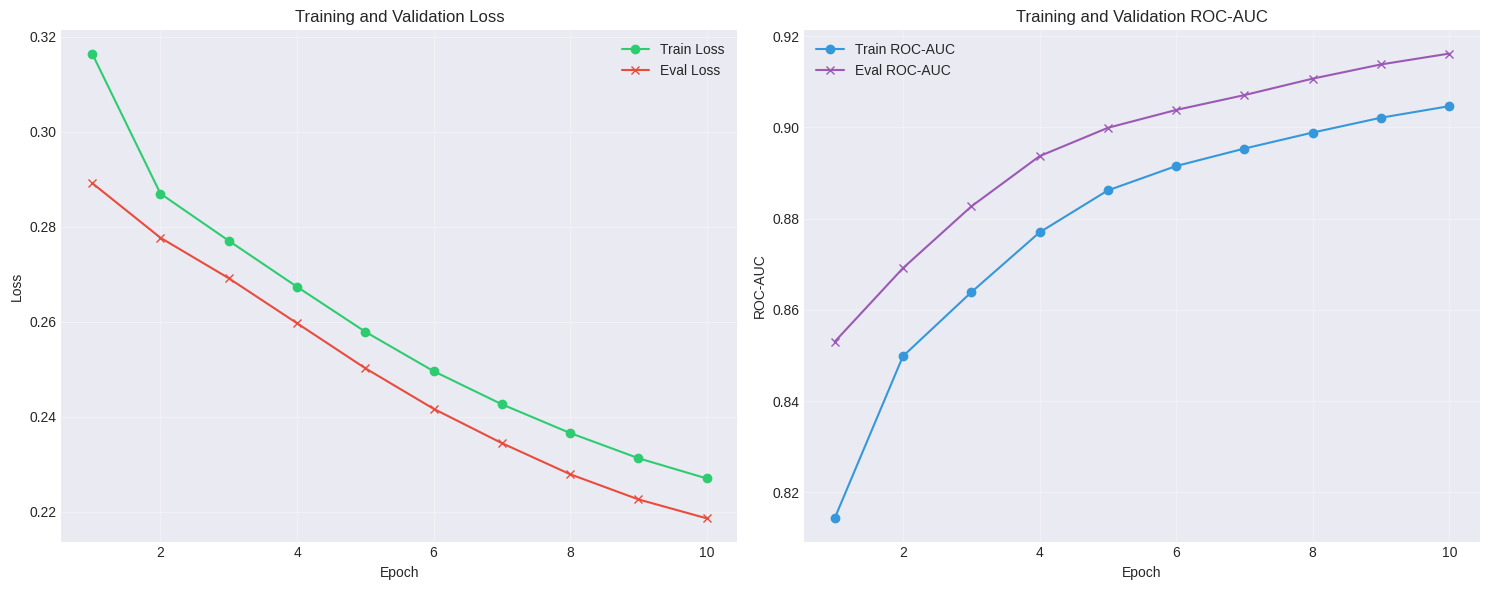

In [19]:
train(base_config, BaseModel, train_dataset, test_dataset)

Device: cuda


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50: Train Loss=0.3164, Train ROC-AUC=0.8143, Eval Loss=0.2892, Eval ROC-AUC=0.8530
Epoch 2/50: Train Loss=0.2870, Train ROC-AUC=0.8498, Eval Loss=0.2777, Eval ROC-AUC=0.8691
Epoch 3/50: Train Loss=0.2770, Train ROC-AUC=0.8638, Eval Loss=0.2691, Eval ROC-AUC=0.8827
Epoch 4/50: Train Loss=0.2673, Train ROC-AUC=0.8770, Eval Loss=0.2597, Eval ROC-AUC=0.8937
Epoch 5/50: Train Loss=0.2579, Train ROC-AUC=0.8862, Eval Loss=0.2502, Eval ROC-AUC=0.8999
Epoch 6/50: Train Loss=0.2496, Train ROC-AUC=0.8915, Eval Loss=0.2417, Eval ROC-AUC=0.9038
Epoch 7/50: Train Loss=0.2426, Train ROC-AUC=0.8954, Eval Loss=0.2344, Eval ROC-AUC=0.9071
Epoch 8/50: Train Loss=0.2365, Train ROC-AUC=0.8989, Eval Loss=0.2279, Eval ROC-AUC=0.9107
Epoch 9/50: Train Loss=0.2312, Train ROC-AUC=0.9021, Eval Loss=0.2226, Eval ROC-AUC=0.9138
Epoch 10/50: Train Loss=0.2270, Train ROC-AUC=0.9046, Eval Loss=0.2186, Eval ROC-AUC=0.9162
Epoch 11/50: Train Loss=0.2238, Train ROC-AUC=0.9066, Eval Loss=0.2157, Eval ROC-AUC=0.91

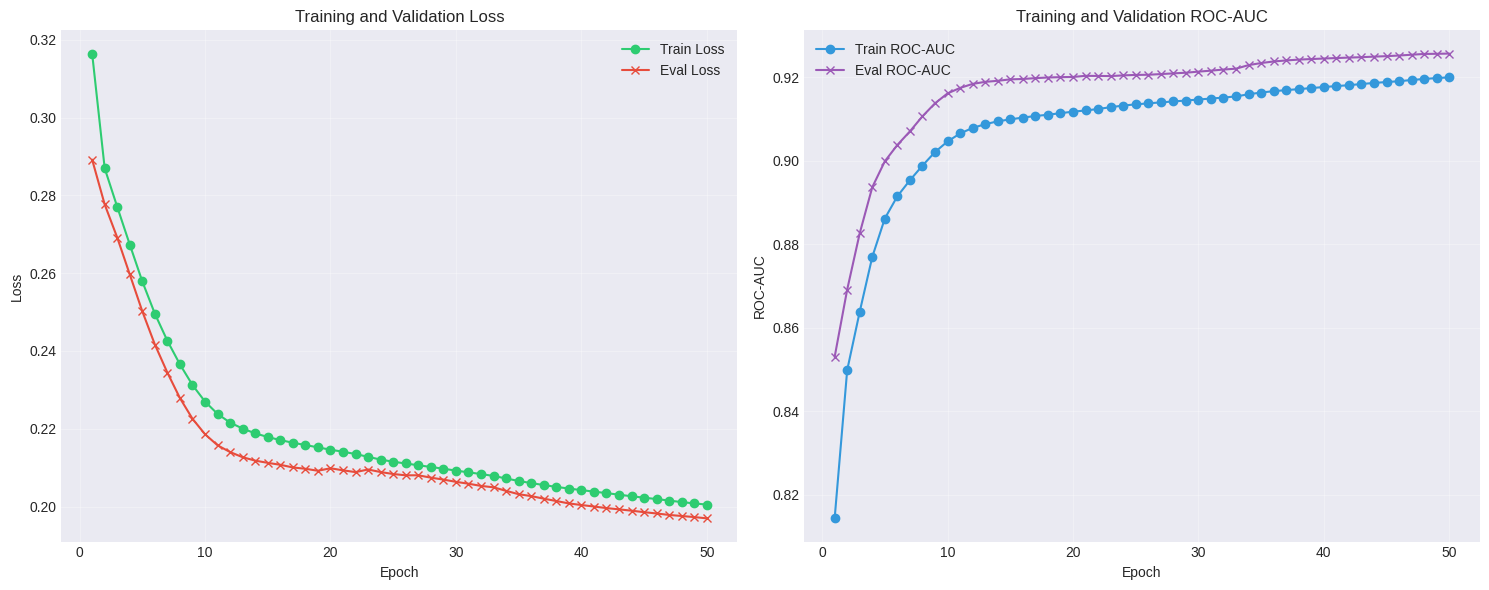

In [20]:
base_config.num_epochs = 50
train(base_config, BaseModel, train_dataset, test_dataset)

# Эксперимент 2. Модель побольше

In [21]:
medium_config = Config(experiment_name='MediumModel',
                     batch_size=32, 
                     hidden_size=128, 
                     lr=0.01, 
                     num_epochs=10, 
                     seed=42)

In [22]:
class MediumBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x 


class MediumModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[MediumBlock(config.hidden_size) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.3365, Train ROC-AUC=0.7872, Eval Loss=0.2922, Eval ROC-AUC=0.8480
Epoch 2/10: Train Loss=0.2874, Train ROC-AUC=0.8447, Eval Loss=0.2778, Eval ROC-AUC=0.8781
Epoch 3/10: Train Loss=0.2721, Train ROC-AUC=0.8662, Eval Loss=0.2633, Eval ROC-AUC=0.8940
Epoch 4/10: Train Loss=0.2592, Train ROC-AUC=0.8802, Eval Loss=0.2500, Eval ROC-AUC=0.9016
Epoch 5/10: Train Loss=0.2488, Train ROC-AUC=0.8893, Eval Loss=0.2391, Eval ROC-AUC=0.9078
Epoch 6/10: Train Loss=0.2403, Train ROC-AUC=0.8958, Eval Loss=0.2304, Eval ROC-AUC=0.9129
Epoch 7/10: Train Loss=0.2330, Train ROC-AUC=0.9007, Eval Loss=0.2227, Eval ROC-AUC=0.9168
Epoch 8/10: Train Loss=0.2273, Train ROC-AUC=0.9043, Eval Loss=0.2190, Eval ROC-AUC=0.9192
Epoch 9/10: Train Loss=0.2229, Train ROC-AUC=0.9069, Eval Loss=0.2160, Eval ROC-AUC=0.9205
Epoch 10/10: Train Loss=0.2194, Train ROC-AUC=0.9089, Eval Loss=0.2132, Eval ROC-AUC=0.9212


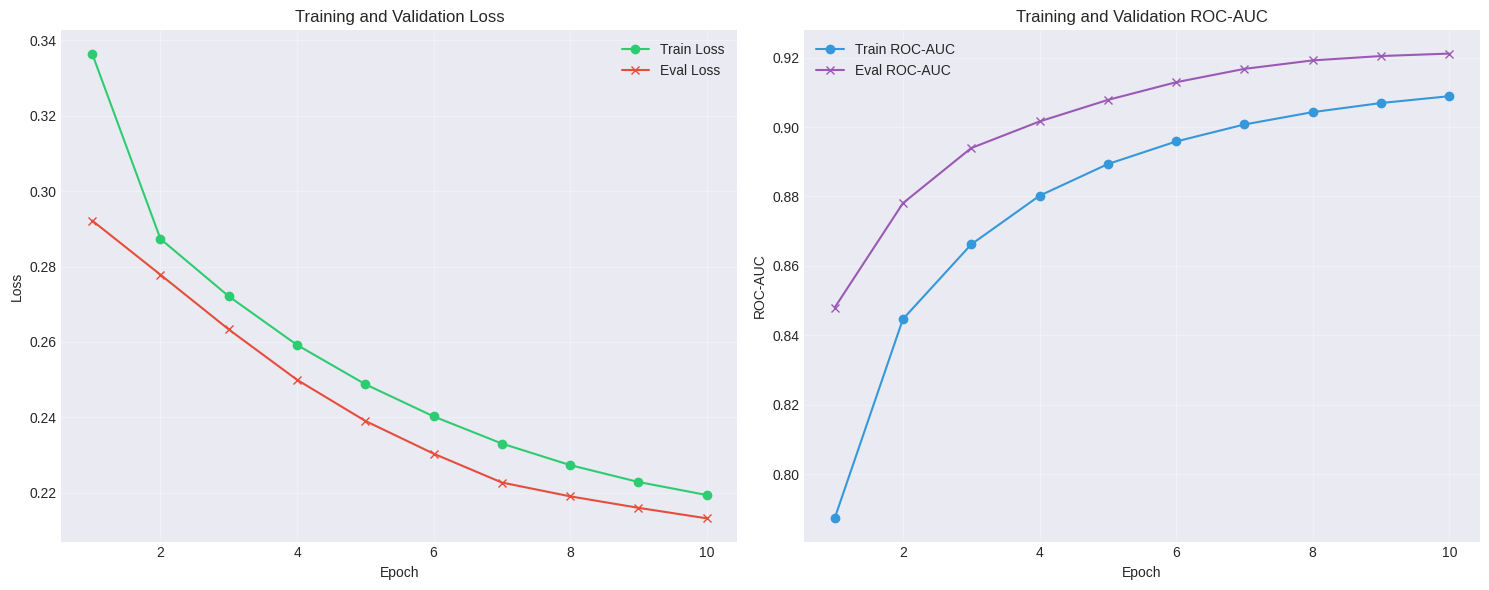

In [23]:
train(medium_config, MediumModel, train_dataset, test_dataset)

# Эксперимент 3. Skip Connections, Batch Norms

In [24]:
class SkipConnectionsBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        x = self.bn(x)
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x + residual


class SkipConnectionsModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[SkipConnectionsBlock(config.hidden_size) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.2932, Train ROC-AUC=0.8384, Eval Loss=0.2747, Eval ROC-AUC=0.8806
Epoch 2/10: Train Loss=0.2695, Train ROC-AUC=0.8717, Eval Loss=0.2617, Eval ROC-AUC=0.8950
Epoch 3/10: Train Loss=0.2564, Train ROC-AUC=0.8843, Eval Loss=0.2521, Eval ROC-AUC=0.8995
Epoch 4/10: Train Loss=0.2461, Train ROC-AUC=0.8921, Eval Loss=0.2460, Eval ROC-AUC=0.9033
Epoch 5/10: Train Loss=0.2376, Train ROC-AUC=0.8982, Eval Loss=0.2433, Eval ROC-AUC=0.9061
Epoch 6/10: Train Loss=0.2317, Train ROC-AUC=0.9024, Eval Loss=0.2420, Eval ROC-AUC=0.9078
Epoch 7/10: Train Loss=0.2277, Train ROC-AUC=0.9053, Eval Loss=0.2406, Eval ROC-AUC=0.9091
Epoch 8/10: Train Loss=0.2247, Train ROC-AUC=0.9075, Eval Loss=0.2389, Eval ROC-AUC=0.9099
Epoch 9/10: Train Loss=0.2221, Train ROC-AUC=0.9093, Eval Loss=0.2367, Eval ROC-AUC=0.9109
Epoch 10/10: Train Loss=0.2199, Train ROC-AUC=0.9108, Eval Loss=0.2349, Eval ROC-AUC=0.9117


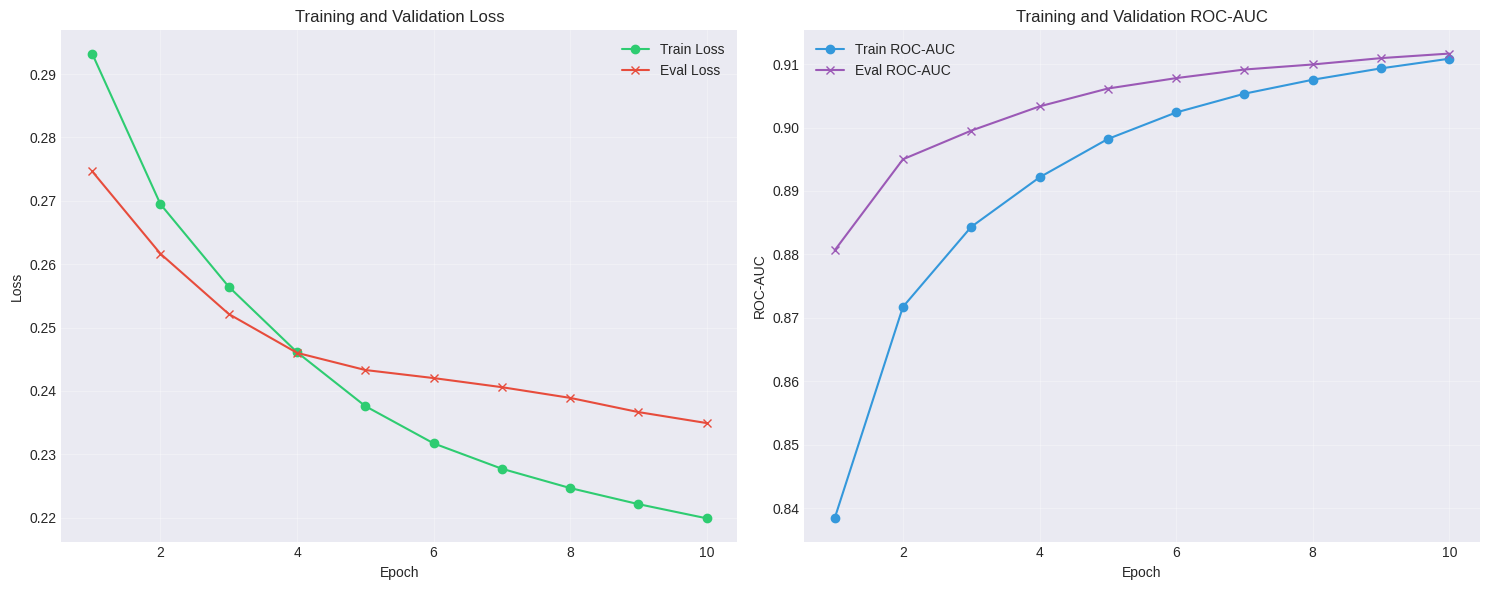

In [25]:
train(medium_config, SkipConnectionsModel, train_dataset, test_dataset)

# Эксперимент 4. Dropout

In [26]:
class DropoutBlock(nn.Module):
    def __init__(self, hidden_size: int, dropout_p: float):
        super().__init__()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_p)  
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        x = self.bn(x)
        x = self.linear_1(x)
        x = self.act(x)
        x = self.dropout(x)  
        x = self.linear_2(x)
        return x + residual


class DropoutModel(nn.Module):
    def __init__(
            self,
            config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[DropoutBlock(config.hidden_size, config.drop_p) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

        self.emb_dropout = nn.Dropout(config.drop_p)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_dropout(self.emb_home(cat_features['home']))
        x_intent = self.emb_dropout(self.emb_intent(cat_features['intent']))
        x_grade = self.emb_dropout(self.emb_grade(cat_features['grade']))
        x_default = self.emb_dropout(self.emb_default(cat_features['cpdof']))

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.01)
Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.2955, Train ROC-AUC=0.8350, Eval Loss=0.2764, Eval ROC-AUC=0.8774
Epoch 2/10: Train Loss=0.2751, Train ROC-AUC=0.8636, Eval Loss=0.2659, Eval ROC-AUC=0.8941
Epoch 3/10: Train Loss=0.2666, Train ROC-AUC=0.8736, Eval Loss=0.2595, Eval ROC-AUC=0.8977
Epoch 4/10: Train Loss=0.2597, Train ROC-AUC=0.8805, Eval Loss=0.2543, Eval ROC-AUC=0.9009
Epoch 5/10: Train Loss=0.2558, Train ROC-AUC=0.8834, Eval Loss=0.2448, Eval ROC-AUC=0.9073
Epoch 6/10: Train Loss=0.2507, Train ROC-AUC=0.8887, Eval Loss=0.2455, Eval ROC-AUC=0.9097
Epoch 7/10: Train Loss=0.2470, Train ROC-AUC=0.8906, Eval Loss=0.2384, Eval ROC-AUC=0.9110
Epoch 8/10: Train Loss=0.2449, Train ROC-AUC=0.8929, Eval Loss=0.2396, Eval ROC-AUC=0.9134
Epoch 9/10: Train Loss=0.2414, Train ROC-AUC=0.8958, Eval Loss=0.2335, Eval ROC-AUC=0.9147
Epoch 10/10: Train Loss=0.2393, Train ROC-AUC=0.8972, Eval Loss=0.2352, Eval ROC-AUC=0.9136


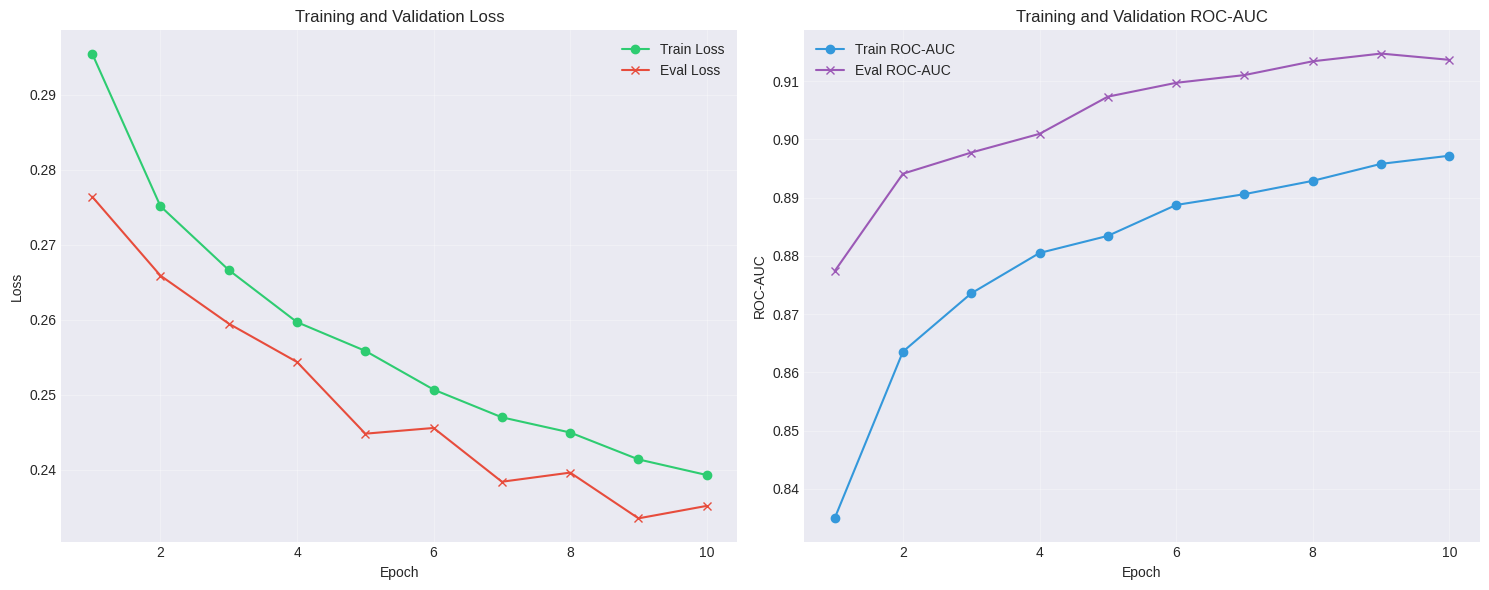

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.1)
Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.3069, Train ROC-AUC=0.8204, Eval Loss=0.2847, Eval ROC-AUC=0.8598
Epoch 2/10: Train Loss=0.2936, Train ROC-AUC=0.8379, Eval Loss=0.2787, Eval ROC-AUC=0.8778
Epoch 3/10: Train Loss=0.2896, Train ROC-AUC=0.8429, Eval Loss=0.2768, Eval ROC-AUC=0.8825
Epoch 4/10: Train Loss=0.2864, Train ROC-AUC=0.8466, Eval Loss=0.2751, Eval ROC-AUC=0.8872
Epoch 5/10: Train Loss=0.2859, Train ROC-AUC=0.8472, Eval Loss=0.2727, Eval ROC-AUC=0.8855
Epoch 6/10: Train Loss=0.2828, Train ROC-AUC=0.8514, Eval Loss=0.2726, Eval ROC-AUC=0.8892
Epoch 7/10: Train Loss=0.2821, Train ROC-AUC=0.8523, Eval Loss=0.2690, Eval ROC-AUC=0.8927
Epoch 8/10: Train Loss=0.2804, Train ROC-AUC=0.8553, Eval Loss=0.2668, Eval ROC-AUC=0.8925
Epoch 9/10: Train Loss=0.2787, Train ROC-AUC=0.8573, Eval Loss=0.2675, Eval ROC-AUC=0.8935
Epoch 10/10: Train Loss=0.2770, Train ROC-AUC=0.8588, Eval Loss=0.2673, Eval ROC-AUC=0.8967


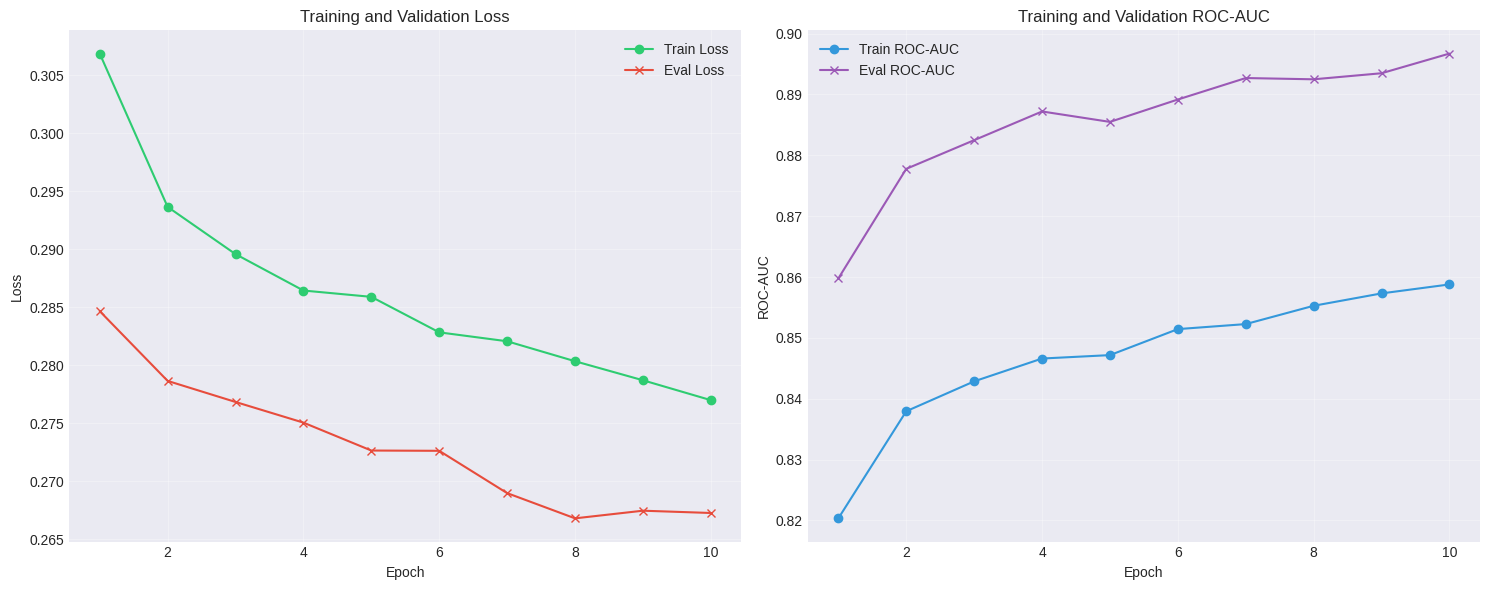

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.2)
Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.3151, Train ROC-AUC=0.8104, Eval Loss=0.2914, Eval ROC-AUC=0.8476
Epoch 2/10: Train Loss=0.3052, Train ROC-AUC=0.8224, Eval Loss=0.2858, Eval ROC-AUC=0.8592
Epoch 3/10: Train Loss=0.3012, Train ROC-AUC=0.8272, Eval Loss=0.2849, Eval ROC-AUC=0.8625
Epoch 4/10: Train Loss=0.2987, Train ROC-AUC=0.8291, Eval Loss=0.2799, Eval ROC-AUC=0.8712
Epoch 5/10: Train Loss=0.2968, Train ROC-AUC=0.8327, Eval Loss=0.2811, Eval ROC-AUC=0.8715
Epoch 6/10: Train Loss=0.2935, Train ROC-AUC=0.8369, Eval Loss=0.2800, Eval ROC-AUC=0.8735
Epoch 7/10: Train Loss=0.2937, Train ROC-AUC=0.8353, Eval Loss=0.2777, Eval ROC-AUC=0.8757
Epoch 8/10: Train Loss=0.2924, Train ROC-AUC=0.8370, Eval Loss=0.2767, Eval ROC-AUC=0.8767
Epoch 9/10: Train Loss=0.2917, Train ROC-AUC=0.8392, Eval Loss=0.2781, Eval ROC-AUC=0.8780
Epoch 10/10: Train Loss=0.2903, Train ROC-AUC=0.8388, Eval Loss=0.2760, Eval ROC-AUC=0.8804


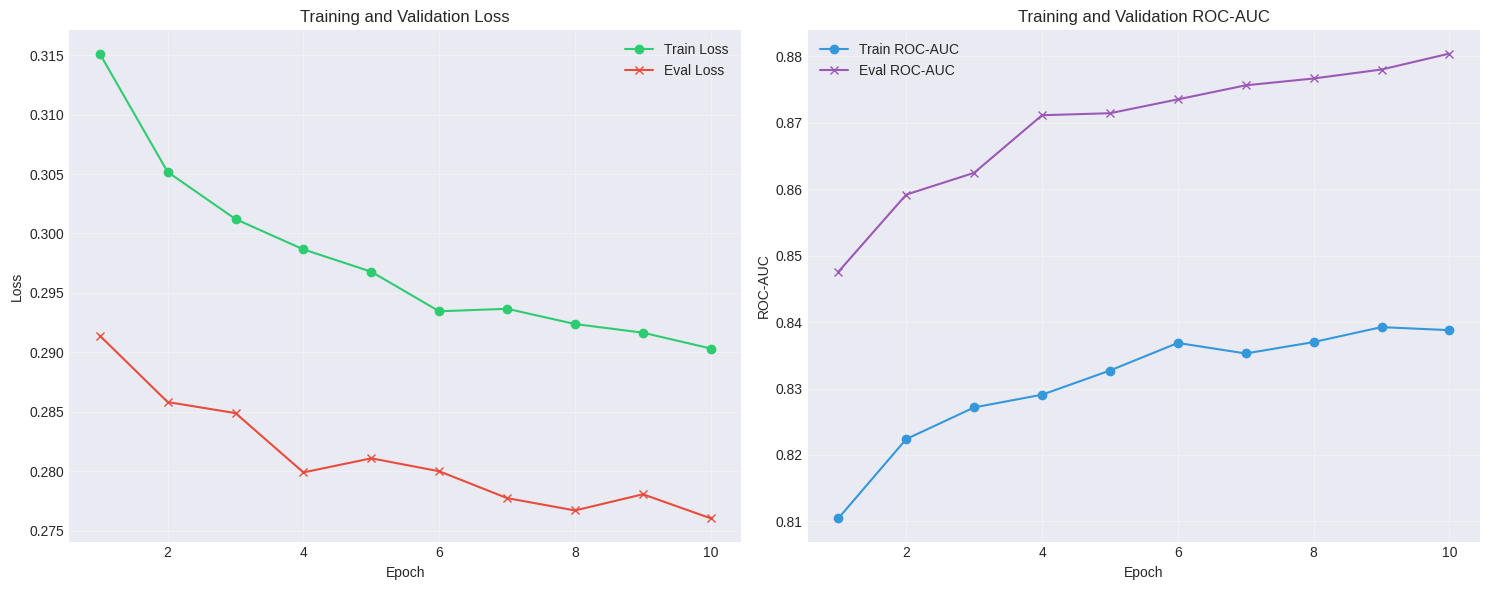

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.5)
Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.3358, Train ROC-AUC=0.7832, Eval Loss=0.3002, Eval ROC-AUC=0.8372
Epoch 2/10: Train Loss=0.3287, Train ROC-AUC=0.7905, Eval Loss=0.2974, Eval ROC-AUC=0.8396
Epoch 3/10: Train Loss=0.3245, Train ROC-AUC=0.7970, Eval Loss=0.3023, Eval ROC-AUC=0.8362
Epoch 4/10: Train Loss=0.3260, Train ROC-AUC=0.7957, Eval Loss=0.2955, Eval ROC-AUC=0.8368
Epoch 5/10: Train Loss=0.3243, Train ROC-AUC=0.7986, Eval Loss=0.2948, Eval ROC-AUC=0.8420
Epoch 6/10: Train Loss=0.3203, Train ROC-AUC=0.8042, Eval Loss=0.2913, Eval ROC-AUC=0.8441
Epoch 7/10: Train Loss=0.3213, Train ROC-AUC=0.8018, Eval Loss=0.2915, Eval ROC-AUC=0.8441
Epoch 8/10: Train Loss=0.3213, Train ROC-AUC=0.8015, Eval Loss=0.2901, Eval ROC-AUC=0.8473
Epoch 9/10: Train Loss=0.3199, Train ROC-AUC=0.8043, Eval Loss=0.2892, Eval ROC-AUC=0.8473
Epoch 10/10: Train Loss=0.3182, Train ROC-AUC=0.8053, Eval Loss=0.2877, Eval ROC-AUC=0.8517


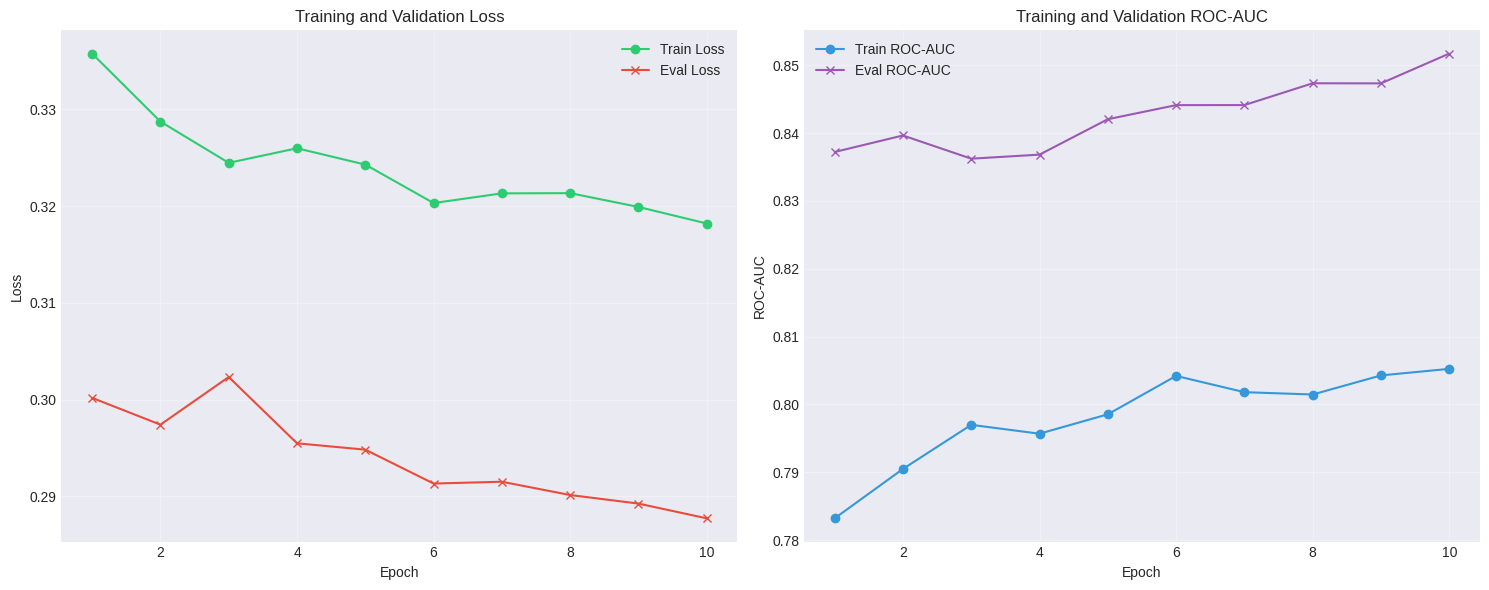

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.9)
Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.4438, Train ROC-AUC=0.6520, Eval Loss=0.3315, Eval ROC-AUC=0.7972
Epoch 2/10: Train Loss=0.4265, Train ROC-AUC=0.6614, Eval Loss=0.3424, Eval ROC-AUC=0.7898
Epoch 3/10: Train Loss=0.4211, Train ROC-AUC=0.6675, Eval Loss=0.3314, Eval ROC-AUC=0.8059
Epoch 4/10: Train Loss=0.4213, Train ROC-AUC=0.6674, Eval Loss=0.3403, Eval ROC-AUC=0.8041
Epoch 5/10: Train Loss=0.4181, Train ROC-AUC=0.6717, Eval Loss=0.3354, Eval ROC-AUC=0.8196
Epoch 6/10: Train Loss=0.4143, Train ROC-AUC=0.6790, Eval Loss=0.3261, Eval ROC-AUC=0.8076
Epoch 7/10: Train Loss=0.4174, Train ROC-AUC=0.6694, Eval Loss=0.3445, Eval ROC-AUC=0.7941
Epoch 8/10: Train Loss=0.4149, Train ROC-AUC=0.6757, Eval Loss=0.3259, Eval ROC-AUC=0.8167
Epoch 9/10: Train Loss=0.4148, Train ROC-AUC=0.6746, Eval Loss=0.3286, Eval ROC-AUC=0.8131
Epoch 10/10: Train Loss=0.4126, Train ROC-AUC=0.6783, Eval Loss=0.3314, Eval ROC-AUC=0.8088


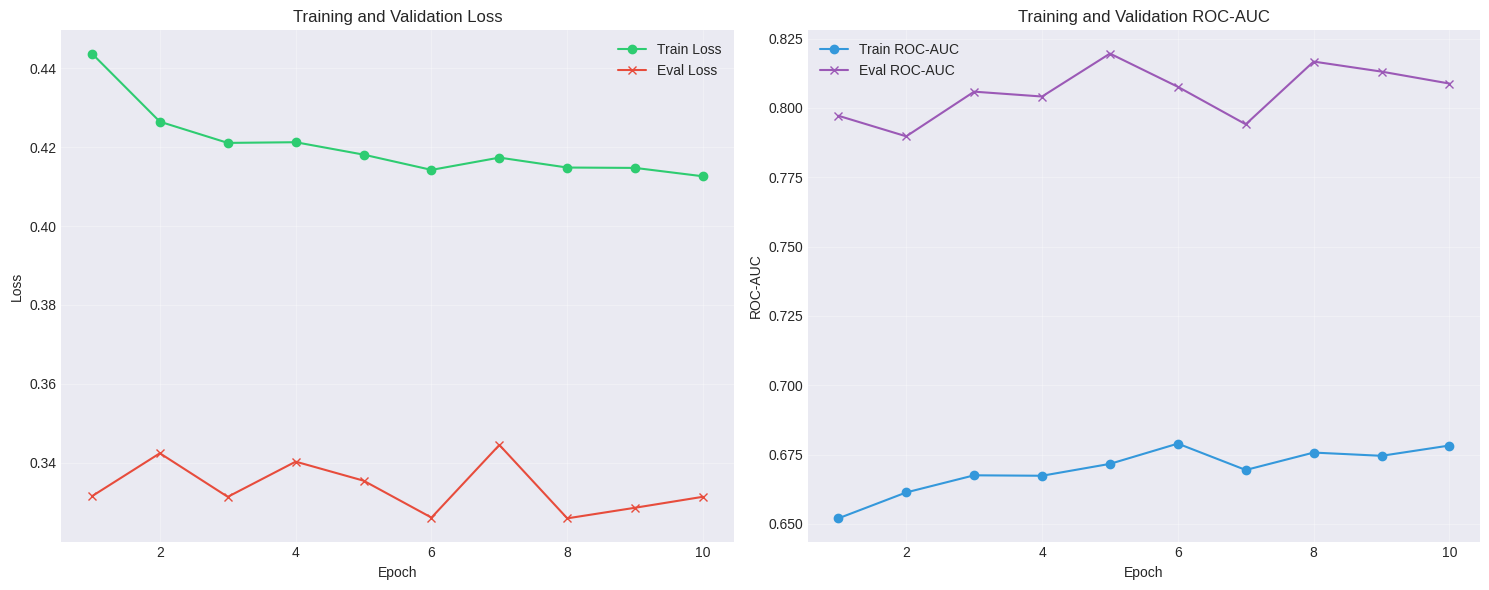

In [27]:
dropout_config = Config(experiment_name='DropoutModel',
                         batch_size=32, 
                         hidden_size=128, 
                         lr=0.01, 
                         num_epochs=10, 
                         seed=42)
dropout_values = [0.01, 0.1, 0.2, 0.5, 0.9]
for dropout_p in dropout_values:
    dropout_config.drop_p = dropout_p
    print(f'Training with config: {dropout_config}')
    train(dropout_config, DropoutModel, train_dataset, test_dataset)

# Эксперимент 5. Weight Decay, Learning Rate

In [28]:
weight_lr_config = Config(experiment_name='WeightLr',
                         batch_size=32, 
                         hidden_size=128, 
                         num_epochs=10, 
                         drop_p=0,
                         lr=0.01, 
                         seed=42)
learning_rates = [0.01, 0.05, 0.1]
weight_decay_values = [0.1, 0.01, 0.001]
for lr, wd in product(learning_rates, weight_decay_values):
    weight_lr_config.lr = lr
    weight_lr_config.weight_decay = wd
    print(f'Training with config: {weight_lr_config}')
    train(weight_lr_config, DropoutModel, train_dataset, test_dataset)

NameError: name 'product' is not defined